# Lumen Data Science

PyTissue

Update or install important libraries

In [1]:
if False:
    !pip install -Uqq fastai
    !pip install -Uqq librosa

In [2]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
import re
import itertools
import matplotlib.pyplot as plot
sys.path.append('../')

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Label getters

In [3]:
path = Path("../Dataset/Dataset/IRMAS_Validation_Data/")
get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#1460) [Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-11.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-12.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-13.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-14.wav'), Path('../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-15.wav')]


In [4]:
def is_IRMAS_train(pat: Path):
    return str(pat).find("IRMAS_Training_Data") != -1

def is_IRMAS_valid(pat: Path):
    return str(pat).find("IRMAS_Validation_Data") != -1
    
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
is_IRMAS_train(song_path), is_IRMAS_valid(song_path)

(False, True)

In [5]:
def get_IRMAS_train_label(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []
song_path = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__1.wav")
get_IRMAS_train_label(song_path)

['cel']

In [6]:
def get_IRMAS_valid_label(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_IRMAS_valid_label(song_path)

['gel', 'voi']

In [7]:
def get_label(pat: Path):
    if is_IRMAS_train(pat):
        return get_IRMAS_train_label(pat)
    if is_IRMAS_valid(pat):
        return get_IRMAS_valid_label(pat)
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_label(song_path)

['gel', 'voi']

## Get items

In [8]:
n_fft = 512  # 1024
hop_length = 256  # 512
f_min = 20
f_max = 8000
sample_rate = 44100

In [9]:
def get_song(pat: Path):
    return librosa.load(pat, sr=None)[0]

In [10]:
def clip_song(clip):
    aplen = sample_rate*3 - len(clip) + 1
    if aplen < 0: aplen = 0
    clip = np.concatenate([clip, np.zeros(aplen)])
    maxran = len(clip)-sample_rate*3
    if maxran <= 0: maxran = 1
    i = np.random.randint(maxran)
    clip = clip[i:i+sample_rate*3]
    return clip

In [11]:
def get_spec(clip):
    stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
    return stft

In [12]:
def spec2mag(stft):
    stft_magnitude, _ = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    return stft_magnitude_db

In [13]:
def get_magspec(pat: Path):
    return spec2mag(get_spec(get_song(pat)))

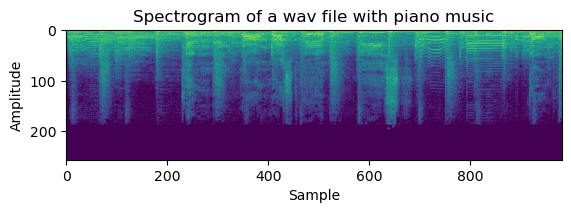

In [14]:
def plot_magspec(stft_magnitude_db):
    plot.title('Spectrogram of a wav file with piano music')
    plot.imshow(spec)
    plot.xlabel('Sample')
    plot.ylabel('Amplitude')
    
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
spec = get_magspec(song_path)
plot_magspec(spec)

## Metrics

In [15]:
def acc(x, y):
    return 1 - (((x > 0.5).float() - y).abs()).float().mean()
acc(torch.tensor([[0.1, 0.9, 0.4], [0.2, 0.2, 0.6]]), torch.tensor([[1, 1, 0], [0, 0, 1]]))

tensor(0.8333)

## Building the model

In [16]:
train_path = Path("../Dataset/Dataset/IRMAS_Training_Data")
valid_path = Path("../Dataset/Dataset/IRMAS_Validation_Data")
path = Path("../Dataset/Dataset/IRMAS_Training_Data")

In [17]:
def get_subset(x, p=0.9):
    return [x[i] for i in RandomSplitter(p)(items)[0]]

In [18]:
get_song_tfms = [get_song, clip_song]
get_label_tfms = [get_label, MultiCategorize(), OneHotEncode()]
get_magimg_tfms = [get_spec, spec2mag, PILImage.create]
get_item_tfms = [get_song_tfms, get_label_tfms]

class LoadSong(ItemTransform):
    def __init__(self, tfms=[get_song_tfms, lambda x: x]):
        self.tfms = tfms
        self.pipes = [Pipeline(tfm) for tfm in tfms]
    
    def encodes(self, item):
        x, y = item
        x, y = self.pipes[0](x), self.pipes[1](y) 
        return [x, y]

In [19]:
class AddRandomSongs(ItemTransform):
    split_idx = 0
    def __init__(self, items, tfms=get_item_tfms, s_num=1, s_amp=0.3, lim=0.5):
        self.items = np.array(items)
        self.pipes = [Pipeline(tfm) for tfm in tfms]
        self.s_num = s_num
        self.s_amp = s_amp
        self.lim = lim
    
    def get_random_songs(self, k):
        files = np.random.choice(self.items, k)
        X = [self.pipes[0](f) for f in files]
        Y = [self.pipes[1](f) for f in files]
        return X, Y
        
    def encodes(self, item):
        x, y = item
        l = np.random.poisson(self.s_num, 1)
        X, Y = self.get_random_songs(l)
        X.append(x)
        Y.append(y)
        ran = np.random.normal(1, self.s_amp, len(X))
        ran[np.where((ran > 1+self.lim) | (ran < 1-self.lim))] = 1
        x = sum(s*r for s, r in zip(X, ran))
        y = TensorMultiCategory([min(i, 1) for i in sum(Y)])
        return [x, y]

In [20]:
class CreateMag(ItemTransform):
    def __init__(self, tfms=get_magimg_tfms):
        self.pipe = Pipeline(tfms)
    def encodes(self, item):
        x, y = item
        return [self.pipe(x), y]

In [21]:
from IPython.display import Audio

class ShowSong(ItemTransform):
    def __init__(self, k=10):
        self.cnt = 0
        self.k = k
    def encodes(self, item):
        x, y = item
        if self.cnt < self.k + 1:
            if 0 < self.cnt:
                display(y)
                display(Audio(data=x, rate=sample_rate))
            self.cnt += 1
        return item


TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.])

TensorMultiCategory([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])

TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.])

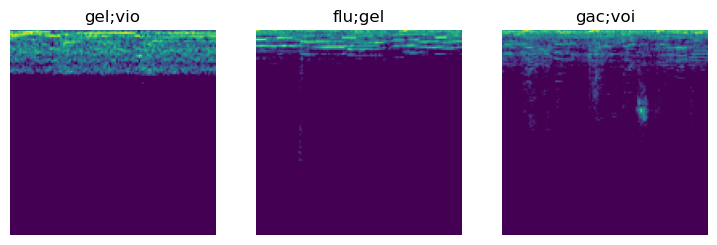

In [22]:
def get_dataset(pat: Path):
    items = get_song_files(pat)
    # items = get_subset(items, p=0.8)
    splitter = RandomSplitter()
    splits = splitter(items)
    return Datasets(items, [get_song_tfms, get_label_tfms], splits=splits)
    
dset = get_dataset(train_path)
song_add_items = [dset.items[i] for i in dset.splits[0]]
dls = dset.dataloaders(bs=64, after_item=[AddRandomSongs(song_add_items, s_num=1.5),
                                          ShowSong(k=3),
                                          CreateMag(),
                                          Resize(128),
                                          ToTensor(),
                                          IntToFloatTensor()])
dls.show_batch(max_n=3)

In [23]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
dls.train

5364
1341


In [24]:
learn = vision_learner(dls, resnet18, metrics=acc)

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,acc,time
0,0.864140,0.456887,0.869975,00:46


epoch,train_loss,valid_loss,acc,time
0,0.637167,0.317010,0.910243,00:46
1,0.542573,0.287683,0.913023,00:46
2,0.494131,0.258671,0.919667,00:46
3,0.475360,0.250071,0.921565,00:46


## Data augmentation

Combine two or more music files

In [26]:
from IPython.display import Audio
x = get_song(Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__3.wav"))
y = get_song(Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0002__3.wav"))
z = 0.5*(x + y)

Audio(data=z, rate=sample_rate)

## Track GPU usage

In [27]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [28]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [29]:
import gc
def report_gpu():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    gc.collect()
    torch.cuda.empty_cache()

In [30]:
report_gpu()

Memory Usage:
Allocated: 0.2 GB
Cached:    0.8 GB


## Tesst on Validation data

In [31]:
tdset = dls.test_dl(get_song_files(valid_path), with_labels=True)
learn.validate(dl=tdset)

(#2) [0.38147586584091187,0.8610212802886963]

In [32]:
learn.validate()

(#2) [0.2500714957714081,0.9215646982192993]

## Gradient Accumulation

In [1]:
def train(arch, accum=1, finetune=True, epochs=12, bs=64):
    _dls = DataBlock(
        blocks = [ImageBlock(), MultiCategoryBlock],
        get_items = get_song_files,
        splitter = RandomSplitter(),
        get_x = get_magspec,
        get_y = get_label
    ).dataloaders(path, bs=bs)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(_dls, arch, metrics=acc, cbs=cbs).to_fp16()
    if finetune:
        learn.fine_tune(epochs, 0.01)
        # return learn.tta(dl=dls.test_dl(tst_files))
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, 0.01)

In [ ]:
# train(resnet18, epochs=6)